In [1]:
import pandas as pd
import numpy as np
import os
import random
import math
import datetime
import matplotlib.pyplot as plt

In [6]:
DATA_FILE_1 = "dataset.txt"
DATA_FILE_2 = "dataset_2.txt"

In [7]:
def plot_cumulative_take_rate(cumulative_take_rates):
    times = [x+2 for x in range(9999)]
    y = []
    for t in times:
        y.append(cumulative_take_rates[t])
    x = np.asarray(times)
    y = np.asarray(y)
    plt.plot(x, y)
    max_index = np.argmax(y)
    max_ctr = y[max_index]
    max_alpha = x[max_index]
    plt.plot(max_alpha, max_ctr, 'r*')
    plt.show()

Below is the strategy one for choosing alpha which is time based. 'alpha' is calculated at each time step and is not a constant throughout the realm of the code.

In [8]:
def find_optimal_alpha_1(time):
    return 1/np.sqrt(time)

In [2]:
def LinUCB_modified(data_file, alpha=0.0, plot_or_not=True):
    articles = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    T = [x+2 for x in range(9999)]
    m = 10 # number of articles
    d = 100 # number of features
    total_payoff = 0.0
    time = 1 # to plot time series
    ctrs = {} # dict of time vs cumulative take rates
    ctr_num = 0.0 # initialising the CTR numerator
    ctr_den = 1.0 # initialising the CTR denominator
    matches = 0.0 # to record the number of matches between predicted arm and actual arm
    first = True
    with open(data_file, 'r') as data_file:
        lines = data_file.readlines()
        for line in lines:
            features = line.split(' ')
            real_article_chosen = features[0]
            reward = features[1]
            features = features[2:102]
            if first:
                first = False
                A = np.zeros((m, d, d))
                for a in range(10):
                    A[a] = np.eye(d)
                b = np.zeros((m, d, 1))
            ratings = np.zeros(m)
            for a in range(10):
                A_inv = np.linalg.inv(A[a])
                theta_a = A_inv.dot(b[a])
                features = np.asarray(features).astype(int)
                features = np.reshape(features, (100, 1))
                # uncomment the below when you want alpha based on time (1/sqrt(T))
                #alpha = find_optimal_alpha_1(time) 
                ratings[a] = np.matmul(theta_a.T, features) + alpha * np.sqrt(np.matmul(np.matmul(features.T, A_inv), features))
            chosen_article = articles[np.random.choice(np.flatnonzero(ratings == ratings.max()))]
            if int(chosen_article) == int(real_article_chosen):
                # print("match at:",time)
                matches += 1.0
                total_payoff += float(reward)
                A[int(real_article_chosen)-1] += features.dot(features.T)
                b[int(real_article_chosen)-1] = b[int(real_article_chosen)-1] + int(reward)* features
                ctr_num += int(reward)
                # to account for the 1.0 initialization of ctr_den instead of 0.0
                if ctr_den != 0.0:
                    ctr_den += 1
                ctrs[time] = ctr_num/(1.0*ctr_den)
            else:
                ctrs[time] = ctr_num/(1.0*ctr_den)
            time += 1
    if plot_or_not:
        plot_cumulative_take_rate(ctrs)
    total_payoff /= matches
    return (ctrs[10000], total_payoff)

Because of the random nature of ties breaking during finding the argmax in the initial call to LinUCB function, we use below function to find an average Cumulative take rate and payoff.

In [29]:
def call_LinUCB(data_file, number, alpha=0.0):
    sum_ctr = 0.0
    sum_payoff = 0.0
    for i in range(number):
        ctr, payoff = LinUCB_modified(data_file)
        sum_ctr += ctr
        sum_payoff += payoff
    return sum_ctr/number, sum_payoff/number

Dataset 1:


Below is the timeseries plot of time vs Cumulative take rate when alpha is chosen using the formula: 1/sqrt(T) i.e. alpha is essentially different at every time step and not a constant in contrast to the other approaches of choosing alpha. Because of this, there are three plots but the overall CTR value is averaged out and used to see how good or bad this approach of choosing alpha is.

As expected, the cumulative take rate and total payoff values are roughly the same because they essentially follow the same formula: Ratio of the successful arms and the number of matches. They are implemented differently to plot the time vs take rate plot.

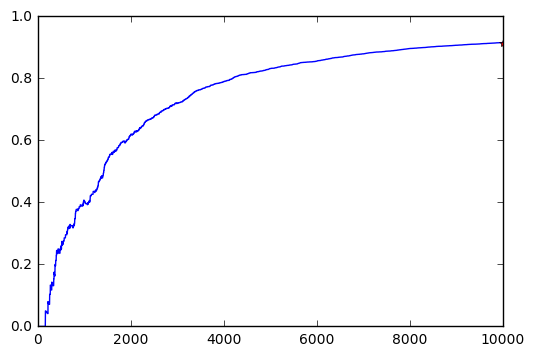

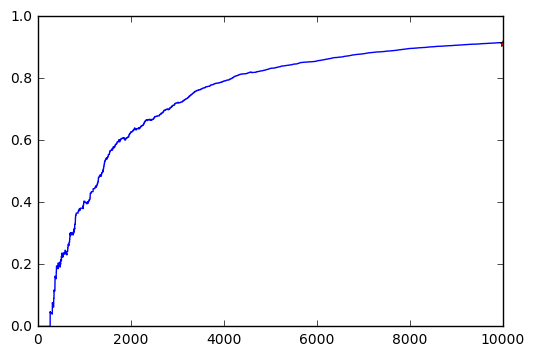

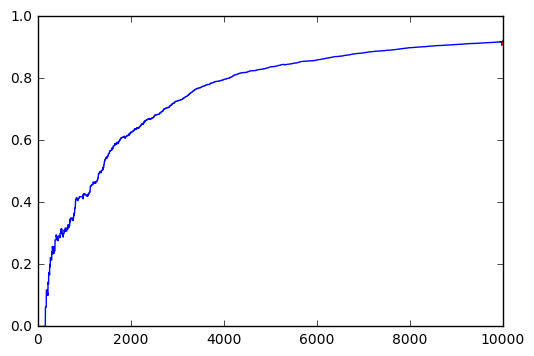

Cumulative Take rate: 0.9165103576099977, Total Payoff: 0.9173907848404492
CPU times: user 8min 10s, sys: 5min 29s, total: 13min 40s
Wall time: 1min 42s


In [19]:
%%time
(ctr, payoff) = call_LinUCB(DATA_FILE_1, 3)
print("Cumulative Take rate: " + str(ctr) + ", Total Payoff: " + str(payoff))

Below is the strategy two of choosing alpha which is a standard grid search. After running single calls, I got an idea of the kind of range which will help reach a good alpha.

In [34]:
def find_optimal_alpha_2():
    values = np.arange(0.0001, 0.02, 0.001)
    ctrs = []
    for a in values:
        ctr, payoff = LinUCB_modified(DATA_FILE_1, alpha=a, plot_or_not=False)
        ctrs.append(ctr)
        print(str(a) + "---" + str(ctr))
    x = np.asarray(values)
    y = np.asarray(ctrs)
    plt.plot(x, y)
    max_index = np.argmax(y)
    max_ctr = y[max_index]
    max_alpha = x[max_index]
    print("alpha with maximum ctr: " + str(max_alpha))
    plt.plot(max_alpha, max_ctr, 'r*')
    plt.show()

0.0001---0.8981206726013847
0.0011---0.9340344168260039
0.0021---0.9432692307692307
0.0031---0.9393063583815029
0.0041---0.9448144624167459
0.0051---0.9479768786127167
0.0061---0.9476190476190476
0.0071---0.9352380952380952
0.0081---0.9365384615384615
0.0091---0.9414634146341463
0.0101---0.9298245614035088
0.011099999999999999---0.9246376811594202
0.0121---0.9211026615969582
0.0131---0.9188156638013372
0.0141---0.918111753371869
0.015099999999999999---0.9165867689357622
0.0161---0.92
0.0171---0.9172346640701071
0.0181---0.9161793372319688
0.0191---0.9132947976878613


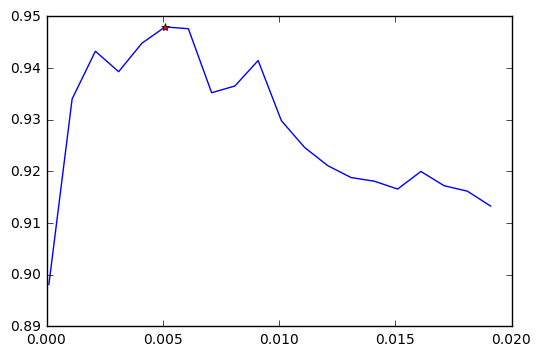

In [33]:
find_optimal_alpha_2()

Below is the strategy 3 of finding an optimal alpha. In this strategy, I am using the idea presented in one of the papers that uses a mathematical formula involving delta parameter which arises from trying to find an upper bound on the difference between the actual and expected reward.

From the formula, it seemed that alpha will definitely be greater than 1 and delta can't be above 2 as that will make the term under square root as negative which isn't possible. Hence that gives an idea about the bounds. I ran one iteration of the code with alpha = 1 and didn't receive a good value of CTR but this strategy is worth looking at because of its theoretical basis.

In [45]:
def find_optimal_alpha_3():
    deltas = np.arange(1, 2, 0.1)
    ctrs = []
    for d in deltas:
        alpha = 1.0 + np.sqrt(math.log(2.0/d)/2)
        ctr, payoff = LinUCB_modified(DATA_FILE_1, alpha, False)
        ctrs.append(ctr)
        print(str(alpha) + "---" + str(ctr))
    x = np.asarray(deltas)
    y = np.asarray(ctrs)
    plt.plot(x, y)
    plt.show()

1.5887050112577374---0.15414634146341463
1.5467343965563263---0.14587525150905434
1.5053838262973946---0.1527777777777778
1.4641028528744755---0.1529175050301811
1.4223002154502955---0.16180620884289745
1.379263808220466---0.15510204081632653
1.3340236154182885---0.153
1.285060458059141---0.1510574018126888
1.22952180251321---0.15991692627206647
1.1601457061359282---0.1850828729281768


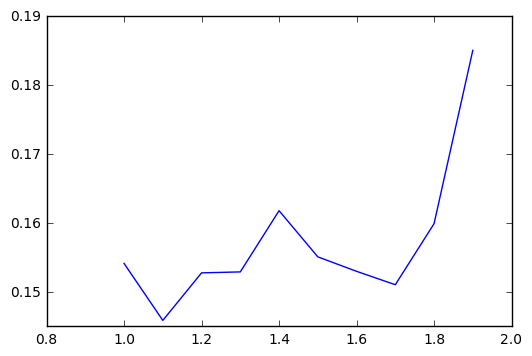

In [46]:
find_optimal_alpha_3()

In [10]:
def LinUCB(data_file, alpha=0.0, plot_or_not=True):
    articles = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    T = [x+2 for x in range(9999)]
    m = 10 # number of articles
    d = 100 # number of features
    time = 1 # to plot time series
    matches = 0.0 # to record the number of matches between predicted arm and actual arm
    first = True
    with open(data_file, 'r') as data_file:
        lines = data_file.readlines()
        for line in lines:
            features = line.split(' ')
            real_article_chosen = features[0]
            features = features[1:101]
            if first:
                first = False
                A = np.zeros((m, d, d))
                for a in range(10):
                    A[a] = np.eye(d)
                b = np.zeros((m, d, 1))
            ratings = np.zeros(m)
            for a in range(10):
                A_inv = np.linalg.inv(A[a])
                theta_a = A_inv.dot(b[a])
                features = np.asarray(features).astype(int)
                features = np.reshape(features, (100, 1))
                # uncomment the below when you want alpha based on time (1/sqrt(T))
                #alpha = find_optimal_alpha_1(time) 
                ratings[a] = np.matmul(theta_a.T, features) + alpha * np.sqrt(np.matmul(np.matmul(features.T, A_inv), features))
            chosen_article = articles[np.random.choice(np.flatnonzero(ratings == ratings.max()))]
            if int(chosen_article) == int(real_article_chosen):
                #print("match at: " + str(time))
                reward = 1.0   
                matches += 1.0
            else:
                reward = 0.0
            A[int(chosen_article)-1] += features.dot(features.T)
            b[int(chosen_article)-1] = b[int(chosen_article)-1] + int(reward)* features
            time += 1
    return (matches)

In [11]:
%%time
matches = LinUCB(DATA_FILE_2, alpha=0.01)
print("Overall number of matches: " + str(matches))

Overall number of matches: 9923.0
CPU times: user 2min 49s, sys: 2min 3s, total: 4min 52s
Wall time: 36.6 s
